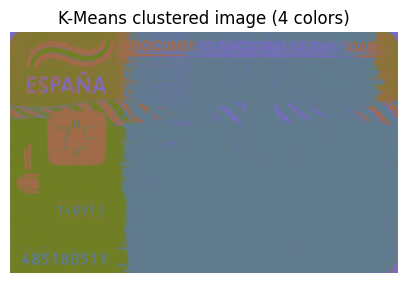

🖼️ Image: esp_id_00.jpg
Reconstruction error: 10.7354
Centroid vector length: 8



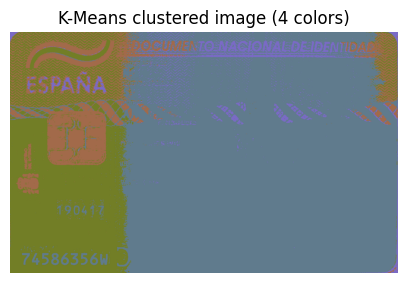

🖼️ Image: esp_id_01.jpg
Reconstruction error: 10.7450
Centroid vector length: 8



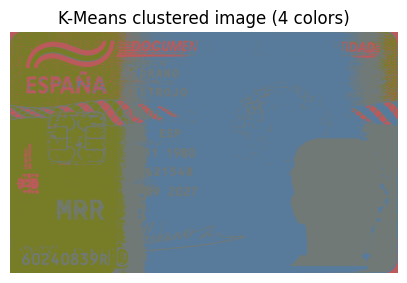

🖼️ Image: esp_id_02.jpg
Reconstruction error: 10.8076
Centroid vector length: 8



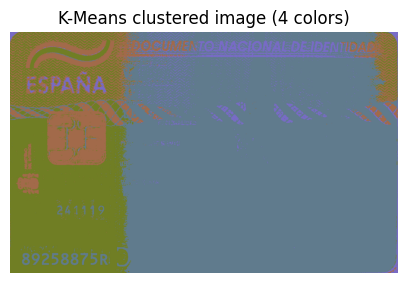

🖼️ Image: esp_id_03.jpg
Reconstruction error: 10.7817
Centroid vector length: 8



KeyboardInterrupt: 

In [2]:
# ==========================
# 📦 Imports
# ==========================
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Display images inline
%matplotlib inline


# ==========================
# 🎨 K-Means clustering for a single image
# ==========================
def kmeans_clustering(image_path, num_clusters=4, show_result=True):
    """
    Perform K-means color clustering on an image.
    Returns a flattened concatenated centroid vector and optionally shows the clustered image.
    """

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"⚠️ Could not load image: {image_path}")
        return None

    # Convert to Lab color space (better perceptual color separation)
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

    # Keep only the a,b channels (color info)
    ab_channels = image_lab[:, :, 1:3]

    # Reshape image into 2D array of pixels (N x 2)
    pixels = ab_channels.reshape((-1, 2)).astype(np.float32)

    # K-Means parameters
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = num_clusters

    # Run K-Means
    _, labels, centers = cv2.kmeans(
        pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS
    )

    centers = np.uint8(centers)
    clustered = centers[labels.flatten()]
    clustered_image = clustered.reshape(ab_channels.shape)

    # Convert Lab->RGB for display (need to reconstruct L channel for proper color)
    # Add a dummy L channel (mid brightness)
    L_channel = np.ones((clustered_image.shape[0], clustered_image.shape[1], 1), dtype=np.uint8) * 128
    clustered_lab = np.concatenate([L_channel, clustered_image], axis=2)
    clustered_rgb = cv2.cvtColor(clustered_lab, cv2.COLOR_Lab2RGB)

    # Show clustered image inline
    if show_result:
        plt.figure(figsize=(5, 5))
        plt.imshow(clustered_rgb)
        plt.axis("off")
        plt.title(f"K-Means clustered image ({num_clusters} colors)")
        plt.show()

    # Compute reconstruction error
    reconstruction_error = np.sqrt(np.mean((pixels - centers[labels.flatten()]) ** 2))
    print(f"🖼️ Image: {os.path.basename(image_path)}")
    print(f"Reconstruction error: {reconstruction_error:.4f}")

    # Get concatenated centroid vector
    concatenated_centroids = generate_concatenated_centroid_vector(labels, centers)
    print(f"Centroid vector length: {len(concatenated_centroids)}\n")

    return concatenated_centroids


# ==========================
# 🔗 Generate concatenated centroid vector
# ==========================
def generate_concatenated_centroid_vector(labels, centers):
    """
    Concatenate cluster centroids ordered by cluster size (descending).
    """
    cluster_sizes = np.bincount(labels.flatten())
    sorted_indices = np.argsort(-cluster_sizes)
    concatenated = centers[sorted_indices].flatten()
    return concatenated


# ==========================
# 📂 Process all images in a folder
# ==========================
def process_folder(folder_path, num_clusters=4, show_each=False):
    """
    Process all images in a folder, run K-Means clustering,
    and visualize the similarity distance matrix.
    """

    concatenated_vectors = []
    image_names = []

    # Gather all valid image files
    valid_exts = (".png", ".jpg", ".jpeg", ".bmp", ".tiff")
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_exts)]

    if not image_files:
        print("⚠️ No valid images found in the folder.")
        return

    # Process each image
    for filename in image_files:
        path = os.path.join(folder_path, filename)
        vec = kmeans_clustering(path, num_clusters, show_result=show_each)
        if vec is not None:
            concatenated_vectors.append(vec)
            image_names.append(filename)

    # Compute pairwise distance matrix
    n = len(concatenated_vectors)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distance_matrix[i, j] = np.linalg.norm(
                concatenated_vectors[i].astype(float) - concatenated_vectors[j].astype(float)
            )

    # Plot distance matrix
    plt.figure(figsize=(6, 6))
    plt.imshow(distance_matrix, cmap="gray", interpolation="nearest")
    plt.colorbar(label="Color distance")
    plt.xticks(range(n), image_names, rotation=90, fontsize=8)
    plt.yticks(range(n), image_names, fontsize=8)
    plt.title(f"Image Color Similarity Matrix (k={num_clusters})")
    plt.tight_layout()
    plt.show()


# ==========================
# ▶️ Example run
# ==========================
# Change this to your image folder path
folder = "Train_spanish_id"  # e.g. folder with .jpg/.png files

# Run clustering on the folder
process_folder(folder, num_clusters=4, show_each=True)


# ID Card Detection, Segmentation & MRZ OCR — Jupyter Notebook (iVCam)
This notebook connects to your phone camera through **iVCam** (or fallback to other cameras), detects an ID card in the video feed, performs perspective correction, segments important regions (face, MRZ, signature, personal info), runs MRZ OCR (Tesseract), and displays results inline.




In [1]:
# ----------------------------
# Cell: Imports and setup
# ----------------------------
# If you haven't installed needed packages in this environment, run:
# !pip install opencv-python numpy pytesseract imutils matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import pytesseract
import imutils
from typing import Optional, Tuple, Dict

%matplotlib inline

# If Tesseract isn't in your PATH (common on Windows), uncomment and set path:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Helper to show images inline (BGR -> RGB conversion)
def show_image(img, title='', figsize=(6,4), cmap=None):
    if img is None:
        print(f"{title}: None")
        return
    if len(img.shape) == 3:
        img_plot = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_plot = img
    plt.figure(figsize=figsize)
    plt.imshow(img_plot, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()


## Camera Access (iVCam) and Test
We try to open camera index 1 by default (iVCam typically appears as a secondary camera).  
If that fails, the script will try other indices (0..4). You can change `CAM_INDEX` if your system uses another index.


In [12]:
CAMERA_INDEX = 0  # or "e2eSoft iVCam"
cap = cv2.VideoCapture(CAMERA_INDEX, cv2.CAP_DSHOW)


✅ Test frame captured from camera index 0. Showing preview:


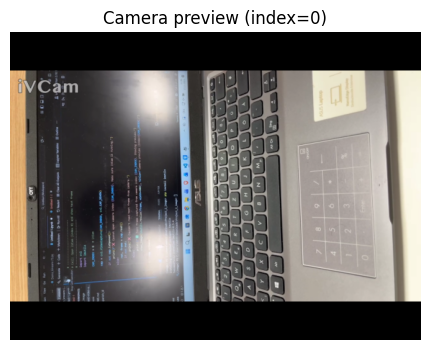

In [27]:
# ----------------------------
# Cell: Open iVCam (index 0) and show test frame
# ----------------------------
import cv2
import imutils

CAM_INDEX = 0  # iVCam

cap = cv2.VideoCapture(CAM_INDEX, cv2.CAP_DSHOW)

if not cap.isOpened():
    print(f"❌ Cannot open camera index {CAM_INDEX}. Make sure iVCam is running.")
else:
    ret, frame = cap.read()
    if not ret:
        print("❌ Couldn't read test frame from camera.")
    else:
        print(f"✅ Test frame captured from camera index {CAM_INDEX}. Showing preview:")
        show_image(imutils.resize(frame, width=800), title=f"Camera preview (index={CAM_INDEX})")

    cap.release()


## Pipeline overview
1. Capture frames continuously from the camera.
2. For each frame:
   - Check quality (blur and glare).
   - Detect largest quadrilateral contour likely to be an ID card.
   - Verify aspect ratio and area to reduce false positives.
   - Perform perspective transform to obtain a top-down view (warped card).
   - Segment candidate regions (MRZ, face, signature, name block) using relative coordinates + face detection for refinement.
   - Preprocess MRZ region and run OCR. If MRZ text is plausible, stop and show results.


In [28]:
# ----------------------------
# Cell: Detection & quality functions
# ----------------------------
def variance_of_laplacian(gray):
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def is_blurry(img, thresh=100.0):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    v = variance_of_laplacian(gray)
    return v < thresh

def has_high_glare(img, v_thresh=240, area_ratio_thresh=0.06):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v = hsv[:,:,2]
    _, mask = cv2.threshold(v, v_thresh, 255, cv2.THRESH_BINARY)
    ratio = (mask>0).sum() / mask.size
    return ratio > area_ratio_thresh

def is_good_frame(frame, blur_thresh=90.0, glare_v=240, glare_area=0.06):
    try:
        if is_blurry(frame, thresh=blur_thresh):
            return False
        if has_high_glare(frame, v_thresh=glare_v, area_ratio_thresh=glare_area):
            return False
        return True
    except Exception as e:
        # If something fails, avoid blocking
        print("Frame quality check error:", e)
        return True

def order_points(pts):
    rect = np.zeros((4,2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def find_card_contour(frame, min_area_ratio=0.02):
    """
    Return 4-point approx contour of detected card or None.
    """
    img = frame.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edged = cv2.Canny(blur, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    h, w = frame.shape[:2]
    min_area = (w*h) * min_area_ratio
    for c in contours:
        area = cv2.contourArea(c)
        if area < min_area:
            continue
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            return approx.reshape(4,2)
    return None

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB))
    dst = np.array([
        [0,0],
        [maxWidth-1,0],
        [maxWidth-1, maxHeight-1],
        [0, maxHeight-1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped


## Segmentation & OCR helpers
This cell includes:
- face detection refinement (Haar cascade)
- segmentation heuristics for MRZ, face, signature, and name block
- MRZ preprocessing and OCR (pytesseract)


In [19]:
# ----------------------------
# Cell: Segmentation & OCR helpers
# ----------------------------
# Face detector (Haar cascade) path included with OpenCV
haar_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(haar_path)

def detect_face_refine(warped):
    """
    Run a face detector on the warped card to refine the face ROI.
    Returns a BGR ROI or None.
    """
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(30,30))
    if len(faces) == 0:
        return None
    # pick the biggest detection
    faces = sorted(faces, key=lambda r: r[2]*r[3], reverse=True)
    x,y,w,h = faces[0]
    return warped[y:y+h, x:x+w].copy()

def extract_card_regions(warped):
    """
    Extract MRZ, face, signature, name_block, and dni candidate from the warped top-down card.
    Uses relative coordinates; adapts to common ID layouts (tweakable).
    """
    h, w = warped.shape[:2]
    regions = {}

    # MRZ: bottom region (approx 12-20% height)
    mrz_h = int(h * 0.18)
    mrz_y = h - mrz_h - int(h*0.01)
    regions['mrz'] = warped[mrz_y:mrz_y+mrz_h, 0:w].copy()

    # Face: prefer face detector; fallback to left-top heuristic
    face_roi = detect_face_refine(warped)
    if face_roi is not None:
        regions['face'] = face_roi
    else:
        face_w = int(w * 0.30)
        face_h = int(h * 0.45)
        regions['face'] = warped[int(h*0.06):int(h*0.06)+face_h, int(w*0.04):int(w*0.04)+face_w].copy()

    # Signature: bottom-center region (just above MRZ)
    sig_h = int(h * 0.12)
    sig_w = int(w * 0.5)
    sig_x = int(w*0.25)
    sig_y = max(0, mrz_y - sig_h - int(h*0.02))
    regions['signature'] = warped[sig_y:sig_y + sig_h, sig_x:sig_x + sig_w].copy()

    # Name block right of face
    name_x = int(w*0.38)
    name_y = int(h*0.08)
    name_w = int(w*0.55)
    name_h = int(h*0.25)
    regions['name_block'] = warped[name_y:name_y+name_h, name_x:name_x+name_w].copy()

    # DNI candidate small area where numbers often lie
    try:
        regions['dni_candidate'] = warped[int(h*0.32):int(h*0.52), int(w*0.60):int(w*0.95)].copy()
    except:
        regions['dni_candidate'] = None

    return regions

def preprocess_mrz_for_ocr(img):
    """
    Preprocess MRZ for OCR: grayscale, upscale, CLAHE, adaptive thresh, morphology, invert.
    Returns a grayscale image ready for pytesseract.
    """
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # upscale
    h, w = gray.shape[:2]
    scale = max(2, int(600 / max(w, h)))
    gray = cv2.resize(gray, (w*scale, h*scale), interpolation=cv2.INTER_LINEAR)

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # adaptive threshold (invert -> white background)
    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY_INV, 25, 12)

    # morphological open/close to clean
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    cleaned = cv2.morphologyEx(thr, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=1)

    # invert back for tesseract (black text on white background)
    cleaned = 255 - cleaned
    return cleaned

def read_mrz_text(mrz_img):
    """
    Given the MRZ region (BGR), preprocess and run pytesseract. Returns cleaned MRZ string.
    """
    proc = preprocess_mrz_for_ocr(mrz_img)
    if proc is None:
        return ""
    # tesseract config: allow uppercase, digits, and '<'
    config = r'-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ<0123456789 --psm 6'
    try:
        raw = pytesseract.image_to_string(proc, config=config)
    except Exception as e:
        print("Tesseract error:", e)
        raw = pytesseract.image_to_string(proc, config='--psm 6')
    # Keep only MRZ-like chars
    cleaned = "".join([c for c in raw if c.isalnum() or c == '<' or c == '\n' or c == ' '])
    cleaned = cleaned.strip()
    return cleaned


## Main capture loop
Below is the main loop that:
- Reopens the camera,
- Reads frames continuously,
- Runs quality checks and detection,
- Warps the card when found,
- Segments regions and runs MRZ OCR,
- Shows inline visual results when a candidate is found,
- Stops automatically when a plausible MRZ is recognized.


In [30]:
import cv2
import imutils

def run_detection_from_camera(cam_index=0,
                              show_intermediate=True,
                              stop_on_success=True,
                              max_frames=1000):
    """
    Capture frames from camera index `cam_index` until an ID card is detected and MRZ recognized.
    Displays live camera feed with optional overlay.
    Returns detection result dict if successful, else None.
    """
    cap = cv2.VideoCapture(cam_index, cv2.CAP_DSHOW)
    if not cap.isOpened():
        print(f"❌ Cannot open camera index {cam_index}. Make sure iVCam is running.")
        return None

    print(f"✅ Camera index {cam_index} opened. Starting capture...")
    found_result = None
    frame_count = 0

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("❌ Failed to grab frame")
                break

            frame_count += 1
            frame_proc = imutils.resize(frame, width=900)

            # Optional: frame quality check
            if not is_good_frame(frame_proc, blur_thresh=70.0, glare_v=240, glare_area=0.08):
                if show_intermediate and frame_count % 30 == 0:
                    print(f"Skipping frame {frame_count} due to blur/glare.")
                continue

            # Detect ID card quadrilateral
            card_quad = find_card_contour(frame_proc, min_area_ratio=0.015)
            overlay = frame_proc.copy()
            if card_quad is not None:
                cv2.polylines(overlay, [card_quad.astype(int)], True, (0,255,0), 3)
                # Warp card for region extraction
                warped = four_point_transform(frame_proc, card_quad)
                if warped.shape[0] < warped.shape[1]:
                    warped = cv2.rotate(warped, cv2.ROTATE_90_COUNTERCLOCKWISE)
                regions = extract_card_regions(warped)
                mrz_text = read_mrz_text(regions['mrz'])
                if is_plausible_mrz_text(mrz_text):
                    print(f"✅ Plausible MRZ detected at frame {frame_count}")
                    found_result = {
                        'frame': frame_count,
                        'warped': warped,
                        'regions': regions,
                        'mrz_text': mrz_text
                    }
                    if stop_on_success:
                        # show final detected regions
                        show_image(imutils.resize(warped, width=800), title="Final warped card")
                        show_image(imutils.resize(regions['face'], width=250), title="Final face crop")
                        show_image(imutils.resize(regions['signature'], width=600), title="Final signature crop")
                        show_image(imutils.resize(regions['mrz'], width=800), title="Final MRZ crop (for OCR)")
                        break

            # Show live feed with overlay
            cv2.imshow("Live Camera Feed", overlay)

            # Exit on 'q' key
            if cv2.waitKey(1) & 0xFF == ord('q'):
                print("Interrupted by user.")
                break

            if frame_count >= max_frames:
                print("Reached max frames. Stopping.")
                break

    finally:
        cap.release()
        cv2.destroyAllWindows()

    return found_result


# Run detection with live preview from iVCam (index 0)
result = run_detection_from_camera(cam_index=0,
                                   show_intermediate=True,
                                   stop_on_success=True,
                                   max_frames=1200)

if result is None:
    print("No ID card with plausible MRZ detected.")
else:
    print("=== RESULT SUMMARY ===")
    print(f"Detected at frame: {result['frame']}")
    print("Recognized MRZ:")
    print(result['mrz_text'])


✅ Camera index 0 opened. Starting capture...
Skipping frame 30 due to blur/glare.
Skipping frame 210 due to blur/glare.
Skipping frame 240 due to blur/glare.
Skipping frame 300 due to blur/glare.
Skipping frame 510 due to blur/glare.
Skipping frame 720 due to blur/glare.
Skipping frame 750 due to blur/glare.
Skipping frame 810 due to blur/glare.
Skipping frame 840 due to blur/glare.
Skipping frame 870 due to blur/glare.
Skipping frame 900 due to blur/glare.
Skipping frame 930 due to blur/glare.
Skipping frame 960 due to blur/glare.
Skipping frame 990 due to blur/glare.
Skipping frame 1020 due to blur/glare.
Skipping frame 1050 due to blur/glare.
Skipping frame 1080 due to blur/glare.
Skipping frame 1110 due to blur/glare.
Skipping frame 1140 due to blur/glare.
Skipping frame 1170 due to blur/glare.
Skipping frame 1200 due to blur/glare.


: 

In [4]:


# 2. IMPORTS
import cv2
import numpy as np
import pytesseract
import imutils
import os
import matplotlib.pyplot as plt
import IPython.display
from PIL import Image as PILImage
import io
import time

# Configure matplotlib for final inline plotting
%matplotlib inline

# --- Main execution block with error handling ---
try:
    # 3. TESSERACT CONFIGURATION
    # ⚠️ UPDATE THIS PATH to your Tesseract installation
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

    if not os.path.exists(pytesseract.pytesseract.tesseract_cmd):
        print("❌ ERROR: Tesseract executable not found at the specified path.")
        print(f"Please update the path: '{pytesseract.pytesseract.tesseract_cmd}'")
        raise FileNotFoundError("Tesseract not found. Update the path and restart.")
    else:
        print("✅ Tesseract executable found.")

    # 4. HELPER FUNCTIONS
    def plot_image(title, image, cmap=None):
        """
        A helper function to display a single static image using Matplotlib.
        """
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(8, 6))
        plt.imshow(image, cmap=cmap)
        plt.title(title)
        plt.axis('off')
        plt.show()

    def order_points(pts):
        """Orders a list of 4 points (x, y) in top-left, top-right, bottom-right, bottom-left order."""
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    def four_point_transform(image, pts):
        """Applies a 4-point perspective warp to an image."""
        rect = order_points(pts)
        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype="float32")
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
        return warped

    def detect_blur(image, threshold=100.0):
        """Detects if an image is blurry. Returns True if blurry."""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        variance = cv2.Laplacian(gray, cv2.CV_64F).var()
        return variance < threshold, variance

    def remove_glare(image):
        """Masks and inpaints bright reflections."""
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        brightness_thresh = 225
        _, glare_mask = cv2.threshold(v, brightness_thresh, 255, cv2.THRESH_BINARY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        glare_mask = cv2.morphologyEx(glare_mask, cv2.MORPH_DILATE, kernel, iterations=2)
        inpainted = cv2.inpaint(image, glare_mask, 3, cv2.INPAINT_TELEA)
        return inpainted

    def segment_regions(image, roi_definitions):
        """Segments regions from a warped image based on percentage definitions."""
        segmented = {}
        (h, w) = image.shape[:2]
        vis_img = image.copy()
        
        for region_name, (y1_p, y2_p, x1_p, x2_p) in roi_definitions.items():
            y1, y2 = int(h * y1_p), int(h * y2_p)
            x1, x2 = int(w * x1_p), int(w * x2_p)
            
            segmented[region_name] = image[y1:y2, x1:x2]
            
            cv2.rectangle(vis_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(vis_img, region_name, (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        return segmented, vis_img

    def ocr_mrz(mrz_img):
        """Performs preprocessing and OCR on the MRZ region."""
        mrz_gray = cv2.cvtColor(mrz_img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        mrz_clahe = clahe.apply(mrz_gray)
        mrz_thresh = cv2.adaptiveThreshold(mrz_clahe, 255, 
                                           cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                           cv2.THRESH_BINARY_INV, 21, 10)
        mrz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        mrz_morph = cv2.morphologyEx(mrz_thresh, cv2.MORPH_CLOSE, mrz_kernel)
        
        # Tesseract Config
        mrz_config = "--psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789<"
        mrz_text = pytesseract.image_to_string(mrz_morph, config=mrz_config).strip()
        
        # Validate
        valid_lines = [line for line in mrz_text.split('\n') if len(line) > 30]
        
        if len(valid_lines) >= 2:
            return "\n".join(valid_lines), mrz_morph, True
        else:
            return mrz_text, mrz_morph, False

    def display_live_frame(frame):
        """Converts an OpenCV frame to a JPEG and displays it in the notebook."""
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im_pil = PILImage.fromarray(img_rgb)
        f = io.BytesIO()
        im_pil.save(f, 'jpeg')
        IPython.display.display(IPython.display.Image(data=f.getvalue()))

    # 5. CONFIGURATION & CONSTANTS

    CAM_INDEX = 1  # Use 0 as requested
    FRAME_RESIZE_HEIGHT = 500.0
    BLUR_THRESHOLD = 100
    ID_ASPECT_RATIO = 1.586
    TARGET_WIDTH = 800
    TARGET_HEIGHT = int(TARGET_WIDTH / ID_ASPECT_RATIO)
    DEBOUNCE_FRAMES = 90  # ~3 seconds at 30fps

    # --- ROI Definitions (y1, y2, x1, x2) as percentages ---
    # ⚠️ You may need to adjust these for your specific ID card layout
    FRONT_ROIS = {
        "Face": (0.05, 0.45, 0.03, 0.30),
        "Signature": (0.48, 0.65, 0.35, 0.65),
        "Data Fields": (0.05, 0.60, 0.35, 0.95),
    }
    BACK_ROIS = {
        "MRZ": (0.70, 0.98, 0.02, 0.98)
    }

    # 6. CAMERA ACCESS & MAIN PROCESSING LOOP
    cap = cv2.VideoCapture(CAM_INDEX)
    
    if not cap.isOpened():
        print(f"❌ ERROR: Could not open camera at index {CAM_INDEX}.")
    else:
        print(f"📸 Camera connected (index {CAM_INDEX}). Starting live feed...")
        
        # --- State Machine ---
        current_state = "SEARCHING_FRONT"
        debounce_counter = 0
        collected_data = {}
        
        try:
            while True:
                ret, frame = cap.read()
                if not ret:
                    print("❌ Camera feed lost.")
                    break
                
                # Create a frame for display and one for processing
                display_frame = frame.copy()
                ratio = frame.shape[0] / FRAME_RESIZE_HEIGHT
                process_frame = imutils.resize(frame, height=int(FRAME_RESIZE_HEIGHT))
                
                # --- Shared Detection Logic ---
                gray = cv2.cvtColor(process_frame, cv2.COLOR_BGR2GRAY)
                blurred = cv2.GaussianBlur(gray, (5, 5), 0)
                edged = cv2.Canny(blurred, 75, 200)
                contours = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
                contours = imutils.grab_contours(contours)
                contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

                screenCnt = None
                for c in contours:
                    peri = cv2.arcLength(c, True)
                    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
                    if len(approx) == 4:
                        screenCnt = approx
                        break
                
                prompt_text = ""
                box_color = (255, 0, 0) # Red: Not found

                # --- State Machine Logic ---
                if current_state == "SEARCHING_FRONT":
                    prompt_text = "Please show the FRONT of the ID card."
                    
                    if debounce_counter > 0:
                        debounce_counter -= 1
                        
                    elif screenCnt is not None:
                        box_color = (0, 255, 255) # Yellow: Candidate found
                        warped = four_point_transform(frame, screenCnt.reshape(4, 2) * ratio)
                        warped = cv2.resize(warped, (TARGET_WIDTH, TARGET_HEIGHT))
                        warped_no_glare = remove_glare(warped)
                        is_blurry, blur_val = detect_blur(warped_no_glare, BLUR_THRESHOLD)
                        
                        if not is_blurry:
                            box_color = (0, 255, 0) # Green: Success
                            print("✅ Front side detected and passed quality check.")
                            
                            # Segment and store front data
                            regions, vis_img = segment_regions(warped_no_glare, FRONT_ROIS)
                            collected_data.update(regions)
                            collected_data['front_visualization'] = vis_img
                            print("🧩 Segmented: Face, Signature, Data Fields")
                            
                            # Change state
                            current_state = "SEARCHING_BACK"
                            debounce_counter = DEBOUNCE_FRAMES
                            
                elif current_state == "SEARCHING_BACK":
                    prompt_text = "Please flip the card to show the BACK (MRZ)."
                    
                    if debounce_counter > 0:
                        prompt_text += f" (Time to flip: {debounce_counter})"
                        debounce_counter -= 1
                    
                    elif screenCnt is not None:
                        box_color = (0, 255, 255) # Yellow: Candidate found
                        warped = four_point_transform(frame, screenCnt.reshape(4, 2) * ratio)
                        warped = cv2.resize(warped, (TARGET_WIDTH, TARGET_HEIGHT))
                        warped_no_glare = remove_glare(warped)
                        is_blurry, blur_val = detect_blur(warped_no_glare, BLUR_THRESHOLD)
                        
                        if not is_blurry:
                            print("✅ Back side detected. Attempting MRZ recognition...")
                            regions, _ = segment_regions(warped_no_glare, BACK_ROIS)
                            mrz_text, mrz_proc, success = ocr_mrz(regions['MRZ'])
                            
                            if success:
                                box_color = (0, 255, 0) # Green: Success
                                print("🔍 MRZ Recognized!")
                                collected_data['mrz_text'] = mrz_text
                                collected_data['mrz_processed_image'] = mrz_proc
                                current_state = "DONE" # All done!
                            else:
                                box_color = (0, 0, 255) # Red: Found but failed OCR
                                print(f"Failed to read MRZ. Retrying... (Raw: {mrz_text[:20]}...)")
                
                elif current_state == "DONE":
                    prompt_text = "Process Complete! Stopping..."
                    box_color = (0, 255, 0)
                
                # --- Update Live Feed ---
                IPython.display.clear_output(wait=True)
                
                # Draw contour on display frame
                if screenCnt is not None:
                    cv2.drawContours(display_frame, [screenCnt.astype(int)], -1, box_color, 2)
                
                # Add prompt text to display frame
                cv2.rectangle(display_frame, (0, 0), (display_frame.shape[1], 40), (0, 0, 0), -1)
                cv2.putText(display_frame, prompt_text, (10, 30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                
                # Display the frame in the notebook
                display_live_frame(display_frame)
                
                if current_state == "DONE":
                    time.sleep(2) # Show "Complete" message for 2 seconds
                    break # Exit the while loop
        
        except KeyboardInterrupt:
            print("Interrupted by user.")
        
        finally:
            # 7. CLEANUP
            cap.release()
            IPython.display.clear_output(wait=True)
            print("Camera released.")

    # 8. FINAL RESULTS
    print("\n---" * 15)
    print("✅ PROCESS COMPLETE: FINAL COLLECTED DATA")
    print("---" * 15)

    if 'mrz_text' in collected_data:
        print("\n🔍 **Recognized MRZ Text:**")
        print("```")
        print(collected_data['mrz_text'])
        print("```")
    else:
        print("\n❌ MRZ text was not successfully recognized.")

    if 'Face' in collected_data:
        print("\n🧩 **Segmented Regions (from Front):**")
        plot_image("Segmented Face", collected_data['Face'])
    
    if 'Signature' in collected_data:
        plot_image("Segmented Signature", collected_data['Signature'])
        
    if 'front_visualization' in collected_data:
        plot_image("Front Side Segmentation Overview", collected_data['front_visualization'])

    if 'mrz_processed_image' in collected_data:
        print("\n⚙️ **Processed MRZ Image (Used for OCR):**")
        plot_image("Processed MRZ", collected_data['mrz_processed_image'], cmap='gray')

except Exception as e:
    print(f"\n❌ An unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()
    if 'cap' in locals() and cap.isOpened():
        cap.release()
        print("Camera released due to error.")

Camera released.

---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
✅ PROCESS COMPLETE: FINAL COLLECTED DATA
---------------------------------------------

❌ MRZ text was not successfully recognized.


## Notes, Troubleshooting & Tuning Tips

- **iVCam setup**: Open the iVCam app on your phone, connect to your PC by USB or Wi-Fi, and ensure the iVCam preview shows your phone feed. The iVCam device usually appears as a camera at index 1 or 2. If not, change `preferred_index` in the `run_detection_from_camera` call or test camera indices manually.

- **Tesseract**: Install Tesseract OCR separately on Windows (https://github.com/tesseract-ocr/tesseract). If Tesseract is not in PATH, set `pytesseract.pytesseract.tesseract_cmd` to the executable path.

- **MRZ accuracy**: If MRZ OCR is noisy:
  - Increase MRZ preprocessing upscale factor.
  - Tune adaptive threshold parameters.
  - Train or use OCRB language pack if available.
  - Restrict character whitelist in the `config` variable.

- **False positives**:
  - Tune `min_area_ratio` in `find_card_contour`.
  - Add aspect ratio checks for typical card sizes (e.g., width/height range).
  - Use color/template matching for Spanish DNI if you want country-specific improvements.

- **Performance**:
  - Downscale frames for detection speed, but keep enough resolution for OCR.
  - For production, move heavier operations to asynchronous threads or process only every Nth frame.

- **If camera can't be found**:
  - Re-open iVCam app on phone, verify PC drivers (iVCam installer), try USB instead of Wi-Fi.
  - Test camera indices with a simple loop to print available indices.

